# **Proyek Pengembangan Sistem Rekomendasi Buku Menentukan solusi permasalahan dengan memilih pendekatan Collaborative Filtering**

### dibuat oleh Muhamad Fahmi

## **Sumber Dataset**
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

# **Download & Import Library**

In [ ]:
!pip install scikit-surprise
!pip install numpy==1.23.5
!pip install tensorflow==2.12.0

  Using cached tensorflow-2.12.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached gast-0.4.0-py3-none-any.whl.metadata (1.1 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached protobuf-4.25.7-cp37-abi3-manylinux2014_x86_64.whl.metadata (541 bytes)
  Using cached tensorboard-2.12.3-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached wrapt-1.14.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
  Using cached jax-0.6.0-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.6.0-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata

In [ ]:
import pandas as pd
import numpy as np

from surprise import accuracy,SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Loading**

In [ ]:
# Memuat dataset dari path lengkap
users = pd.read_csv('/content/drive/MyDrive/dataset/Users.csv')
books = pd.read_csv('/content/drive/MyDrive/dataset/Books.csv')
ratings =  pd.read_csv('/content/drive/MyDrive/dataset/Ratings.csv')

<ipython-input-4-230275da198a>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/drive/MyDrive/dataset/Books.csv')


# Data Understanding

## Lihat Dataset
Melihat isi dataset dari data users, books dan ratings

- data users

In [ ]:
# Menampilkan 5 baris pertama data users untuk memahami strukturnya
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


- data books

In [ ]:
# Menampilkan 5 baris pertama data books untuk memahami strukturnya
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


- data ratings

In [ ]:
# Menampilkan 5 baris pertama data ratings untuk memahami strukturnya
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# Eksplorasi Data

- Bentuk dari dataset

In [ ]:
print("Data books memiliki shape :" ,books.shape)
print("Data users memiliki shape :", users.shape)
print("Data ratings memiliki shape :", ratings.shape)

Data books memiliki shape : (271360, 8)
Data users memiliki shape : (278858, 3)
Data ratings memiliki shape : (1149780, 3)


Dari bentuk dataset ditemukan informasi yaitu :

1. Data book memiliki 8 kolom dan 271,360 records
2. Data user memiliki 3 kolom dan 278,858 records
3. Data rating memiliki 3 kolom dan 1,149,780 records

- Info fitur Dataset

In [ ]:
# Menampilkan informasi dataset
users.info()
print('Check null value di data users')
users.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
Check null value di data users


,0
User-ID,0
Location,0
Age,110762


Dari informasi dataset books tidak ditemukan fitur numerik

In [ ]:
# Menampilkan informasi dataset
books.info()
print('Check null value di data books')
books.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
Check null value di data books


,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


In [ ]:
# Menampilkan informasi dataset
ratings.info()
print('Check null value di data ratings')
ratings.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
Check null value di data ratings


,0
User-ID,0
ISBN,0
Book-Rating,0


- Total record dataset dan relasi

In [ ]:
n_uniq_book = len(books.ISBN.unique())
n_user = len(users["User-ID"].unique())
n_rating = len(ratings)
n_book_rating = len(ratings["ISBN"].unique())
n_user_rating = len(ratings["User-ID"].unique())

print("Jumlah data buku : ", n_uniq_book)
print("Jumlah data pembaca : ", n_user)
print("Jumlah data rating :", n_rating)
print ("Jumlah pembaca yang memberi rating :", n_user_rating)
print ("Jumlah buku yang diberi rating :", n_book_rating)

Jumlah data buku :  271360
Jumlah data pembaca :  278858
Jumlah data rating : 1149780
Jumlah pembaca yang memberi rating : 105283
Jumlah buku yang diberi rating : 340556


# Eksplorasi Data Univariate
## Data books
Dilakukan explorasi data univariate terhadap variabel-variabel di dataset books. Variabel yang dipilih untuk dieksplorasi adalah variabel yang dianggap menggambarkan dataset books.

In [ ]:
def get_count_percentage(df):
  count_df = df.value_counts()
  percentage = df.value_counts(normalize=True) * 100
  return pd.DataFrame({'jumlah record':count_df, 'persentase':percentage.round(1)})

Variabel Year-Of-Publication

In [ ]:
df_year = books["Year-Of-Publication"]
df_year_int = df_year[df_year.astype(str).str.isdigit() == True].astype(int)

df_year_pub_info = get_count_percentage(df_year_int)
print(df_year_pub_info)


df_year_words = df_year[~df_year.astype(str).str.isdigit() ]
print('Tahun yang memiliki nilai string adalah ', df_year_words.to_numpy())


print('Tahun yang lebih dari 2023 adalah ', df_year_int[df_year_int.gt(2023)].unique())

                     jumlah record  persentase
Year-Of-Publication                           
2002                         17627         6.5
1999                         17431         6.4
2001                         17359         6.4
2000                         17232         6.4
1998                         15766         5.8
...                            ...         ...
1910                             1         0.0
1934                             1         0.0
1914                             1         0.0
1904                             1         0.0
2037                             1         0.0

[116 rows x 2 columns]
Tahun yang memiliki nilai string adalah  ['DK Publishing Inc' 'Gallimard' 'DK Publishing Inc']
Tahun yang lebih dari 2023 adalah  [2030 2050 2038 2026 2024 2037]


Dari value_count ditemukan informasi sebagai berikut:

- Terdapat tahun terbit yang lebih dari 2023 yaitu tahun terbit 2030,2050,2038,2026,2024,2037
- Terdapat record yang memiliki tahun terbit yang tidak valid yang berisi 'DK Publishing Inc' dan 'Gallimard'

Visualisasi jumlah record terhadap tahun terbit dapat dilihat dibawah ini

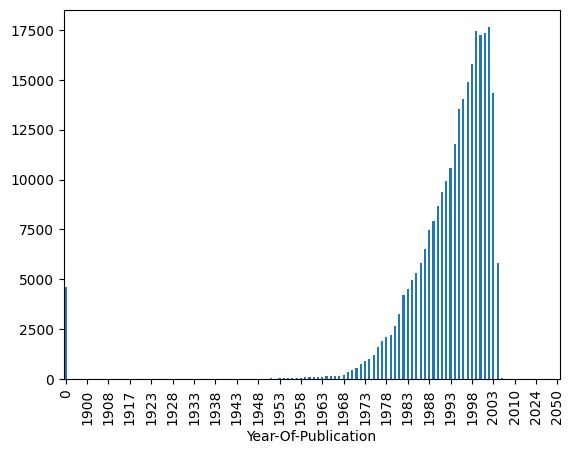

In [ ]:
year_min = df_year_int.min()
year_max = df_year_int.max()
n_steps = 500
year_ticks = np.arange(year_min, year_max + 1, n_steps)

ax = df_year_pub_info['jumlah record'].sort_index().plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::5])

Variabl Books-Author

                      jumlah record  persentase
Book-Author                                    
Agatha Christie                 632         0.2
William Shakespeare             567         0.2
Stephen King                    524         0.2
Ann M. Martin                   423         0.2
Carolyn Keene                   373         0.1
...                             ...         ...
Linda Jackson                     1         0.0
Artiste C. Arthur                 1         0.0
Emily Pearl Kingsley              1         0.0
Jean Cassels                      1         0.0
Christopher  Biffle               1         0.0

[102022 rows x 2 columns]


<Axes: title={'center': '10 Nama Penulis Buku Terbanyak'}, ylabel='Book-Author'>

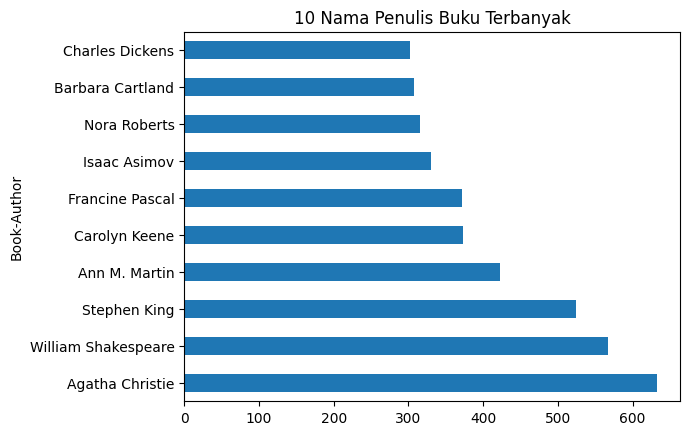

In [ ]:
df_author = books["Book-Author"]

df_author_info = get_count_percentage(df_author)
print(df_author_info)

df_author_info['jumlah record'].head(10).plot(kind='barh', title='10 Nama Penulis Buku Terbanyak')

Dari value_count author dan grafik bar author didapatkan informasi untuk dataset ini adalah sebagai berikut:

- Terdapat 102,023 nama penulis buku
- Persentase penulis buku terbesar adalah 0.2 % sehingga dapat disimpulkan value dari Book-Author memiliki keragaman yang sangat banyak dan tidak didominasi oleh penulis buku tertentu
- 3 Penulis buku terbanyak adalah Agatha Christie, William Shakespeare dan Stephen King

Variable Publisher

                         jumlah record  persentase
Publisher                                         
Harlequin                         7535         2.8
Silhouette                        4220         1.6
Pocket                            3905         1.4
Ballantine Books                  3783         1.4
Bantam Books                      3646         1.3
...                                ...         ...
Hannover House                       1         0.0
Amber Quill Press, LLC.              1         0.0
Lunchbox Press                       1         0.0
Ugly Town                            1         0.0
Connaught                            1         0.0

[16807 rows x 2 columns]


<Axes: title={'center': '10 Nama Publisher Buku Terbanyak'}, ylabel='Publisher'>

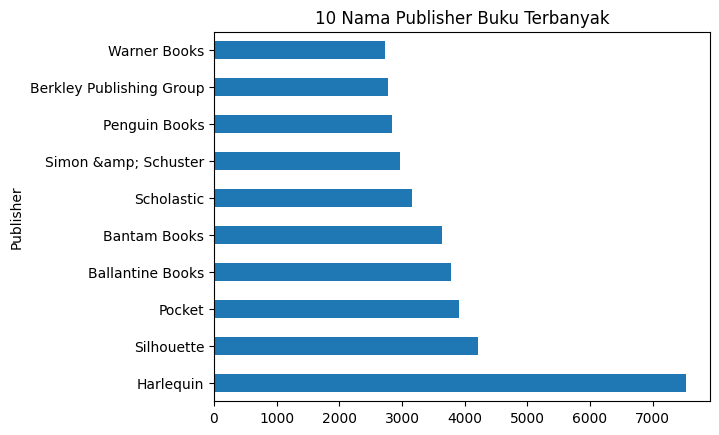

In [ ]:
df_publisher = books["Publisher"]

df_publisher_info = get_count_percentage(df_publisher)
print(df_publisher_info)

df_publisher_info['jumlah record'].head(10).plot(kind='barh', title='10 Nama Publisher Buku Terbanyak')

Dari value_count publisher dan grafik bar publisher didapatkan informasi untuk dataset ini adalah sebagai berikut:

- Terdapat 16,807 nama penerbit
- Persentase penerbit buku terbanyak adalah 2.8 % yaitu Harlequin selisih 1% dengan publisher peringkat kedua yaitu Silhouette
- 3 penerbit buku terbanyak adalah Harlequin, Silhouette dan Pocket

Data users

Tidak dilakukan eksplorasi data univariate untuk dataset users karena sistem rekomendasi tidak mempertimbangkan data umur dan demografi user

# Data ratings
Variabel Book-Rating

             jumlah record  persentase
Book-Rating                           
0                   716109        62.3
8                   103736         9.0
10                   78610         6.8
7                    76457         6.6
9                    67541         5.9
5                    50974         4.4
6                    36924         3.2
4                     8904         0.8
3                     5996         0.5
2                     2759         0.2
1                     1770         0.2


<Axes: title={'center': 'Frekuensi jumlah rating'}, xlabel='Book-Rating'>

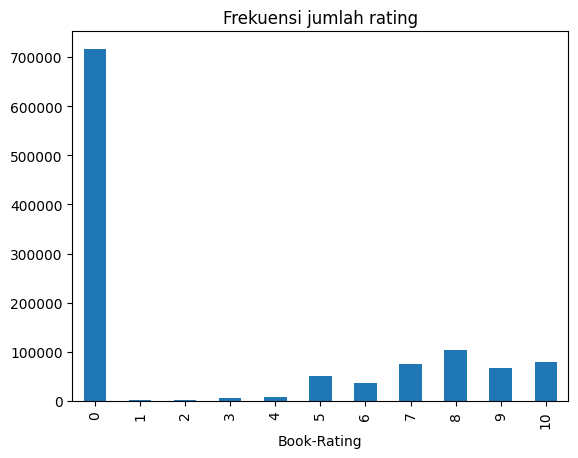

In [ ]:
df_rating = ratings["Book-Rating"]

df_rating_info = get_count_percentage(df_rating)
print(df_rating_info)

df_rating_info['jumlah record'].sort_index().plot(kind='bar', title='Frekuensi jumlah rating')

Dari value_count rating dan plot bar frekuensi rating didapatkan informasi sebagai berikut:

- Jumlah pembaca yang belum memberikan penilaian ke buku (rating = 0) masih sangat banyak yaitu sebesar 62%
- Nilai rating yang sering muncul setelah rating 0 adalah rating 8

# Data Preprocessing
Pada tahap Data Preprocessing dilakukan 2 langkah yaitu :

- Penggabungan Data
- Hapus Variabel yang Tidak Digunakan

# Penggabungan Data
Dilakukan penggabungan data books dengan data ratings

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
merged_book_df = ratings.merge(books, on='ISBN')
merged_book_df.head(5)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...


# Hapus Variabel Yang Tidak Digunakan
Menghapus variabel-variabel yang tidak digunakan di pengembangan proyek dengan motode collaborative filtering yaitu

- Image-URL-S
- Image-URL-M
- Image-URL-L
- Book-Title
- Book-Author
- Year-Of-Publication
- Publisher

In [ ]:
from sys import breakpointhook
column_to_drop = ['Image-URL-S','Image-URL-M','Image-URL-L','Book-Title','Book-Author','Year-Of-Publication','Publisher']
book_rating_df = merged_book_df.drop(column_to_drop, axis =1)
book_rating_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# Data Preparation

Pada tahap ini akan dilakukan langkah-langkah sebagai berikut:

- Mengatasi Missing Value
- Encoding Data
- Skala Ulang Variabel Book-Rating
- Pembagian Data Uji dan Data Latih

# Mengatasi Missing Value

In [ ]:
book_rating_df.isnull().sum()

,0
User-ID,0
ISBN,0
Book-Rating,0


# Encoding Data
Dilakukan encoding ID untuk ISBN dan User-ID ke dalam indeks integer

In [ ]:
user_ids = book_rating_df['User-ID'].unique().tolist()
user_encoded = {x: i for i, x in enumerate(user_ids)}
user_to_user_encoded = {i: x for i, x in enumerate(user_ids)}

book_ids = book_rating_df['ISBN'].unique().tolist()
book_encoded = {x: i for i, x in enumerate(book_ids)}
book_to_book_encoded = {i: x for i, x in enumerate(book_ids)}

print('Encoded user-id :', dict(list(user_encoded.items())[0: 10]))
print('Encoded book-id (isbn) :', dict(list(book_encoded.items())[0: 10]))

Encoded user-id : {276725: 0, 276726: 1, 276727: 2, 276729: 3, 276733: 4, 276744: 5, 276746: 6, 276747: 7, 276748: 8, 276751: 9}
Encoded book-id (isbn) : {'034545104X': 0, '0155061224': 1, '0446520802': 2, '052165615X': 3, '0521795028': 4, '2080674722': 5, '038550120X': 6, '0425115801': 7, '0449006522': 8, '0553561618': 9}


Kemudian memetakan data hasil encode ke dataframe dengan menambahkan kolom baru yaitu kolom user_id dan isbn

In [ ]:
book_rating_df['user_id'] = book_rating_df['User-ID'].map(user_encoded)
book_rating_df['isbn'] = book_rating_df['ISBN'].map(book_encoded)
book_rating_df.head()

,User-ID,ISBN,Book-Rating,user_id,isbn
0,276725,034545104X,0,0,0
1,276726,0155061224,5,1,1
2,276727,0446520802,0,2,2
3,276729,052165615X,3,3,3
4,276729,0521795028,6,3,4


# Skala Ulang Variabel Book-Rating
Dilakukan normalisai terhadap variabel Book-Rating yaitu merubah nilai rating menjadi nilai dengan batas skala 0 sampai 1 agar mudah dalam proses training

- Mengubah nilai Book-Rating menjadi float

In [ ]:
col_rating = 'Book-Rating'
book_rating_df[col_rating] = book_rating_df[col_rating].values.astype(np.float32)

- Mengambil nilai min dan max Book-Rating

In [ ]:
min_rating = min(book_rating_df[col_rating])
max_rating = max(book_rating_df[col_rating])

- Menambahkan variabel baru di dataframe dengan nama rating

In [ ]:
book_rating_df['rating'] = book_rating_df[col_rating].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
book_rating_df.head()

,User-ID,ISBN,Book-Rating,user_id,isbn,rating
0,276725,034545104X,0.0,0,0,0.0
1,276726,0155061224,5.0,1,1,0.5
2,276727,0446520802,0.0,2,2,0.0
3,276729,052165615X,3.0,3,3,0.3
4,276729,0521795028,6.0,3,4,0.6


# Pembagian Data Latih dan Data Uji
Membagi data menjadi data uji dan data latih dengan perbandingan 80% data latih dan 20% data uji.

Pembagian data uji dan data latih ini akan dilakukan dengan 2 cara yang berbeda. Hal ini dikarenakan untuk teknik SVD pembagian data uji dan data latih menggunakan modul train_test_split dari library suprise. Berikut masing-masing cara pembagian data uji dan lati.

Pembagian data uji dan latih untuk teknik SVD
Di library Surprise terdapat class bernama Reader yang berfungsi untuk membaca file rating. Struktur file rating ini harus mengikuti struktur seperti dibawah ini

     user ; item ; rating ; [timestamp]
dengan nilai timestamp adalah optional. Di class Reader juga terdapat parameter rating_scale yang berfungsi sebagai skala rating dengan default nilai (1,5). Di proyek ini rating_scale akan menggunakan (0,1)

In [ ]:
reader_svd = Reader(rating_scale=(0,1))
data_svd = Dataset.load_from_df(book_rating_df[['user_id', 'isbn', 'rating']], reader_svd)
trainset_svd, testset_svd = train_test_split(data_svd, test_size=0.2)

- Pembagian data uji dan latih untuk teknik Neural Network

In [ ]:
x = book_rating_df[['user_id','isbn']].values
y = book_rating_df['rating'].values

n_train = 0.8
train_indices = int(n_train * book_rating_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[    0     0]
 [    1     1]
 [    2     2]
 ...
 [92103  6450]
 [92104 10387]
 [92105 65528]] [0.  0.5 0.  ... 0.  1.  1. ]


# Modelling
Dalam proyek ini sistem rekomendasi dikembangkan dengan menggunakan metode collaborative filtering. Dari metode ini digunakan dua teknik pendekatan yaitu

- Collaborative filtering dengan teknik SVD
- Collaborative filtering dengan teknik Neural Network

Untuk keperluan uji coba model dibuat data test buku yang belum dibaca oleh user sesuai dengan nilai User-ID

In [ ]:
test_user_id = 276729
read_books = ratings[ratings['User-ID'] == test_user_id]
unread_books =  ratings[~ratings['ISBN'].isin(read_books.ISBN.values)]['ISBN']

# Collaborative Filtering dengan Teknik SVD
SVD (Singular Value Decomposition) merupakan teknik aljabar linear yang digunakan untuk mengurangi dimensi dari matrix. Dengan SVD kita dapat menemukan relasi antar anggota di dalam matrix

Library yang digunakan untuk mengimplementasikan SVD adalah Supris

In [ ]:
svd = SVD()

svd.fit(trainset_svd)

Hasil prediksi model teknik SVD untuk 8 buku yang disaranka

In [ ]:
df_svd_predict = unread_books.to_frame(name='ISBN')
df_svd_predict = df_svd_predict.merge(books[['ISBN','Book-Title','Book-Author']], left_on='ISBN', right_on='ISBN', how='left')
df_svd_predict['prediction_rate'] = unread_books.apply(lambda x: svd.predict(test_user_id, x).est)

n_top = 8
df_svd_predict.sort_values(by='prediction_rate',ascending=False).head(n_top)

,ISBN,Book-Title,Book-Author,prediction_rate
0,034545104X,Flesh Tones: A Novel,M. J. Rose,0.283956
766517,0671665871,GOING HOME,Danielle Steel,0.283956
766523,0671690582,WHISPER OF DEATH : WHISPER OF DEATH,Christopher Pike,0.283956
766522,0671690094,ANNE FRANK: DIARY OF A YOUNG GIRL,Anne Frank,0.283956
766521,067167630X,BOOMER,Charles Taylor,0.283956
766520,067167465X,BEST OF ENEMIES (NANCY DREW HARDY BOY SUPERMYS...,Carolyn Keene,0.283956
766519,0671673513,The SILENCE OF THE LAMBS,Thomas Harris,0.283956
766518,0671670662,WEB OF DREAMS (Casteel Saga (Paperback)),V.C. Andrews,0.283956


# Collaborative Filtering dengan Teknik Neural Network
Collaborative filtering dengan teknik Neural Network ini terinspirasi dari siturs Keras yang menggunakan class RecommenderNet.
- Pertama buat class RecommenderNet dengan keras Model class Class ini akan menghitung match score antara user dan book menggunakan dot product kemudian hasil ini ditambahkan dengan bias user dan bias book. Terakhir nilai match score di skala ulang menjadi 0 sampai 1 menggunakan sigmoid activation

In [ ]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_books, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_books = num_books
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.book_embedding = layers.Embedding( # layer embeddings book
        num_books,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.book_bias = layers.Embedding(num_books, 1) # layer embedding book bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    book_vector = self.book_embedding(inputs[:, 1]) # memanggil layer embedding 3
    book_bias = self.book_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, book_vector, 2)

    x = dot_user_resto + user_bias + book_bias

    return tf.nn.sigmoid(x) # activation sigmoid

- Buat model Membuat model menggunakan BinaryCrossentropy untuk hitung loss function, Adam (Adaptive Momment Estimation) untuk optimizer dan RMSE sebagai metriks evaluasi

In [ ]:
embedding_size = 50
num_users = len(book_rating_df['user_id'])
num_books = len(book_rating_df['isbn'])

model_nn = RecommenderNet(num_users, num_books, embedding_size)
model_nn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Hasil prediksi model teknik Neural Network untuk 8 buku yang disarankan

In [ ]:
unread_isbns = list(set(unread_books).intersection(set(book_encoded.keys())))
unread_isbns_encode = [[(book_encoded.get(x))] for x in unread_isbns]

user_encoder = user_encoded.get(test_user_id)
user_book_array =  np.hstack(([[user_encoder]] * len(unread_isbns_encode), unread_isbns_encode))

pred_ratings = model_nn.predict(user_book_array).flatten()

8443/8443 [==============================] - 12s 1ms/step


In [ ]:
top_ratings_indices = pred_ratings.argsort()[-n_top:][::-1]
recommended_book_isbns = [book_to_book_encoded.get(unread_isbns_encode[x][0]) for x in top_ratings_indices]
df_nn_predict = books[books['ISBN'].isin(recommended_book_isbns)]
df_nn_predict[['ISBN','Book-Title','Book-Author']]

,ISBN,Book-Title,Book-Author
25708,0380753006,Savage Thunder,Johanna Lindsey
50457,0373832133,No Quarter Asked,Janet Dailey
130108,8478097325,El barÃ³ de MaldÃ i les bÃ¨sties de l'infern ...,Juan Perucho
133833,1562199064,LA Blue Girl Collection: A Very Graphic Novel ...,Matt Lunsford
153569,0345421418,The Tenth Planet: Oblivion (Tenth Planet),Dean Wesley Smith
181567,0671684965,KAMIKAZE LEGACY,Jerry Ahern
221018,155074089X,Taking the long way home (Maggie and Cyril),Ted Staunton
227411,0451621425,Gandhi: His Life and Message for the World,Louis Fischer


# Evaluation
Evaluasi model menggunakan metriks RMSE (Root Mean Square Error)

In [ ]:
rmse = pd.DataFrame(columns=['test'], index=['SVD','NeuralNetwork'])

- Evaluasi collaborative filtering untuk teknik SVD

  Evaluasi menggunakan modul accuracy dari library Surprise

In [ ]:
predictions = svd.test(testset_svd)
rmse.loc['SVD','test'] = accuracy.rmse(predictions)

RMSE: 0.3434


- Evaluasi collaborative filtering untuk teknik Neural Network

In [ ]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model_nn.fit(
    x = x_train,
    y = y_train,
    batch_size = 500,
    epochs = 8,
    validation_data = (x_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/8
1650/1650 [==============================] - 3164s 2s/step - loss: 0.5912 - root_mean_squared_error: 0.3804 - val_loss: 0.6973 - val_root_mean_squared_error: 0.4449
Epoch 2/8
1650/1650 [==============================] - 3153s 2s/step - loss: 0.5859 - root_mean_squared_error: 0.3707 - val_loss: 0.7094 - val_root_mean_squared_error: 0.4435
Epoch 3/8
1650/1650 [==============================] - 3161s 2s/step - loss: 0.6855 - root_mean_squared_error: 0.4063 - val_loss: 0.7200 - val_root_mean_squared_error: 0.4418


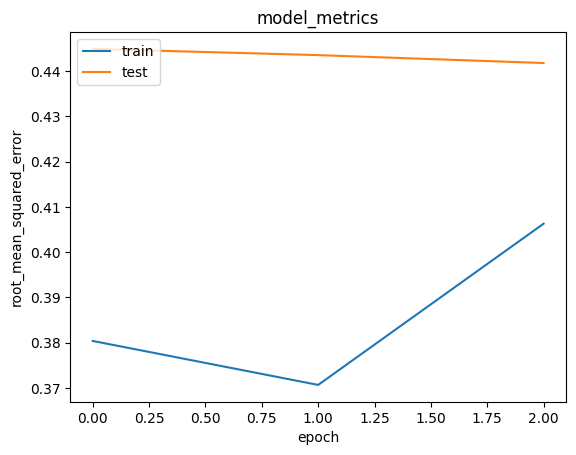

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Mengambil nilai RMSE terkahir dari val_root_mean_squared_error

In [ ]:
rmse.loc['NeuralNetwork','test'] = history.history['val_root_mean_squared_error'][-1]

In [ ]:
rmse

,test
SVD,0.343416
NeuralNetwork,0.441751


Dilihat dari tabel diatas terlihat bahwa nilai RMSE dengan menggunakan teknik NeuralNetwork lebih Besar. Meskipun hanya memiliki selisih sedikit tetapi di teknik Neural Network masih dapat di tingkatkan lagi dengan mengatur hyperparameter yang lebih baik.

Sehingga teknik Neural Network untuk metode collaborative filtering dipilih sebagai algoritma sistem rekomendasi buku.

# Conclusion
Sistem rekomendasi buku sudah berhasil dibuat dengan metode collaborative filtering dengan teknik Neural Network. Pemilihan teknik Neural Network dipilih berdasarkan parameter RMSE yang lebih Besar sedikit.

Meskipun demikian proyek ini kedepannya masih perlu perbaikan dari sisi dataset dan hyperparameter untuk teknik Neural Network.